## PyTorch 학습 레벨 3
---

### PyTorch Recipes 06

### Flask로 배포하기

이 레시피에서는 다음과 같은 내용들을 학습합니다:

- 학습한 PyTorch 모델을 Flask 컨테이너로 감싸고 웹 API로 노출하는 방법

- 웹 요청(request)을 모델에 입력하기 위해 PyTorch 텐서(tensor)로 변환하는 방법

- 모델의 결과를 HTTP 응답(response)로 패키징하는 방법

### 필요사항
아래와 같은 패키지들(과 의존성이 있는 패키지들)이 설치된 Python 3 환경이 필요합니다:

- PyTorch 1.5
- TorchVision 0.6.0
- Flask 1.1

선택 사항으로, 일부 예제 파일들(supporting files)을 받기 위해서 git이 필요합니다.

PyTorch와 TorchVision 설치방법은 pytorch.org 에서 확인하실 수 있습니다. Flask 설치 방법은 Flask 설치 문서 에서 확인하실 수 있습니다.

### Flask란?

Flask는 Python으로 작성된 가벼운 웹 서버입니다. 학습한 PyTorch 모델의 예측을 위한 웹 API를 편리하게 작성하여, 직접 사용하거나 더 큰 시스템에 포함된 웹 서비스를 만들 수 있습니다.

### 설치 및 예제 파일

이미지를 받아서 ImageNet 데이터셋의 1000개 클래스(class) 중 하나로 예측(map)하는 웹 서비스를 만들려고 합니다. 이를 위해 테스트할 이미지 파일들이 필요합니다. 선택 사항으로, 모델이 예측한 클래스 번호(index)를 사람이 읽을 수 있는 클래스 이름으로 바꾸기 위한 파일을 받을 수도 있습니다.

### 옵션 1: 예제 파일 모두를 빠르게 받기

TorchServe 저장소에 체크아웃하여 예제 파일 모두를 가져오고(pull), 작업 폴더로 복사할 수 있습니다. (안내: 이 튜토리얼은 TorchServe에 어떠한 의존성도 갖지 않습니다. - 단순히 빠르게 파일들을 가져오기 위한 방법입니다) 아래 명령을 쉘에서 실행하세요:

- 아래는 깃허브 레포지토리에서 두개의 파일을 다운로드 하기 위한 예제입니다. 
- 단순히 웹 브라우저에서 다운로드 해도 무방합니다.

In [1]:
git clone https://github.com/pytorch/serve
cp serve/examples/image_classifier/kitten.jpg .
cp serve/examples/image_classifier/index_to_name.json .

Cloning into 'serve'...
Updating files:  51% (916/1775)
Updating files:  52% (923/1775)
Updating files:  53% (941/1775)
Updating files:  54% (959/1775)
Updating files:  55% (977/1775)
Updating files:  56% (994/1775)
Updating files:  57% (1012/1775)
Updating files:  58% (1030/1775)
Updating files:  59% (1048/1775)
Updating files:  60% (1065/1775)
Updating files:  61% (1083/1775)
Updating files:  62% (1101/1775)
Updating files:  63% (1119/1775)
Updating files:  64% (1136/1775)
Updating files:  65% (1154/1775)
Updating files:  66% (1172/1775)
Updating files:  67% (1190/1775)
Updating files:  68% (1207/1775)
Updating files:  69% (1225/1775)
Updating files:  70% (1243/1775)
Updating files:  71% (1261/1775)
Updating files:  72% (1278/1775)
Updating files:  73% (1296/1775)
Updating files:  74% (1314/1775)
Updating files:  75% (1332/1775)
Updating files:  76% (1349/1775)
Updating files:  77% (1367/1775)
Updating files:  78% (1385/1775)
Updating files:  79% (1403/1775)
Updating files:  80% (142

이제 파일들을 받았습니다!

#### 사용이미지

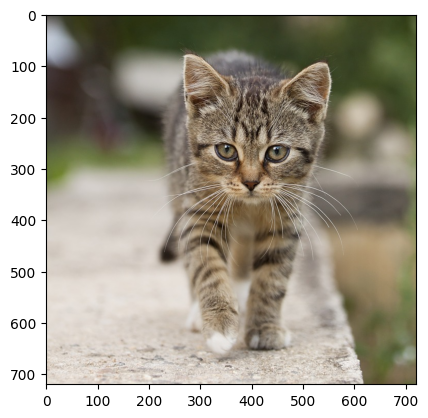

In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('kitten.jpg')
img_np = np.array(img) ## 행렬로 변환된 이미지
plt.imshow(img_np) ## 행렬 이미지를 다시 이미지로 변경해 디스플레이
plt.show() ## 이미지 인터프린터에 출력

#### 옵션 2: 이미지 직접 가져오기
index_to_name.json 파일은 아래 Flask 서비스에서 선택 사항입니다. 직접 가져온 이미지(물론 3색 JPEG 이미지여야 합니다)도 테스트를 할 수 있습니다.

#### Flask 서비스 구축하기
Flask 서비스를 구성하는 전체 Python 스크립트는 이 레시피의 끝 부분에 있습니다; app.py 파일에 복사해서 붙여넣을 수 있습니다. 아래에서 각각의 기능들을 명확히 살펴보기 위해 각 섹션별로 살펴보겠습니다.

#### Import

In [2]:
!pip install Flask

  Using cached flask-3.1.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached flask-3.1.0-py3-none-any.whl (102 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)


In [3]:
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, jsonify, request

순서대로:

- 미리 학습된 DenseNet을 `torchvision.models` 에서 가져와서 사용할 것입니다.
- `torchvision.transforms` 에는 이미지 데이터를 다룰 도구들이 포함되어 있습니다.
- Pillow (`PIL`) 는 이미지 파일을 처음 불러올 때 사용할 것입니다.
- 물론 `flask` 의 클래스들도 필요합니다.

#### 전처리(Pre-Processing)

In [4]:
def transform_image(infile):
    input_transforms = [transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225])]
    my_transforms = transforms.Compose(input_transforms)
    image = Image.open(infile)
    timg = my_transforms(image)
    timg.unsqueeze_(0)
    return timg

웹 요청으로 이미지 파일을 받지만, 모델은 (N, 3, 224, 224) 모양(shape)의 PyTorch 텐서가 필요합니다. 여기서 N 은 입력 배치(input batch)의 항목의 개수입니다. (배치의 크기는 1입니다.) 먼저 이미지의 크기를 조정(resize)하고 자르고, 텐서로 변환한 뒤, 정규화(normalization)하는 TorchVision transforms(변환) 세트를 구성합니다. (정규화에 대한 자세한 내용은 `torchvision.models_` 문서를 참고하세요.)

그런 다음, 파일을 열고 (위에서 구성한) 변환들을 적용합니다. 결과로는 3개의 컬러채널을 갖는 244x244 크기의 이미지므로 (3, 224, 224) 모양으로 반환됩니다. 이 하나의 이미지를 배치로 만들어야 하므로, `unsqueeze_(0)` 을 사용하여 텐서에 첫번째 차원을 추가해줍니다. 텐서는 같은 데이터를 갖지만 모양(shape)이 (1, 3, 224, 224)이 되었습니다.

일반적으로 이미지 데이터에 작업을 하지 않더라도, HTTP 요청(request)으로 받은 입력을 PyTorch에서 사용할 수 있도록 텐서로 변환해야 합니다.

#### 추론(Inference)

In [5]:
def get_prediction(input_tensor):
    outputs = model.forward(input_tensor)
    _, y_hat = outputs.max(1)
    prediction = y_hat.item()
    return prediction

추론 자체는 가장 간단한 부분입니다: 입력 텐서를 모델에 전달하면, 모델은 이미지가 특정 클래스에 속할 것으로 추정하는 가능성(likelihood)을 나타내는 값들의 텐서를 반환합니다. `max()` 를 호출하여 가장 가능성이 높은 클래스를 찾고, ImageNet 클래스 번호(index)에 해당하는 값을 반환합니다. 마지막으로, item() 을 호출하여 텐서에 포함된 클래스 번호(index)를 추출하여 반환합니다.

#### 후처리(Post-Processing)

In [6]:
def render_prediction(prediction_idx):
    stridx = str(prediction_idx)
    class_name = 'Unknown'
    if img_class_map is not None:
        if stridx in img_class_map is not None:
            class_name = img_class_map[stridx][1]

    return prediction_idx, class_name

`render_prediction()` 메소드(method)는 예측된 클래스 번호(index)를 사람이 읽을 수 있는 클래스 라벨(label)에 매핑합니다. 모델에서 예측 값을 얻은 후에는 후처리를 수행하여 사람이 소비하거나 다른 소프트웨어에서 사용할 수 있도록 준비하는 것이 일반적입니다.

#### 전체 Flask App 실행

아래 내용을 `app.py` 파일에 붙여넣습니다:

In [8]:
import io
import json
import os

import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, jsonify, request


app = Flask(__name__)
model = models.densenet121(pretrained=True)               # ImageNet의 1000개 클래스를 학습
model.eval()                                              # autograd 끄기



img_class_map = None
mapping_file_path = 'index_to_name.json'                  # 사람이 읽을 수 있는 ImageNet 클래스 이름
if os.path.isfile(mapping_file_path):
    with open (mapping_file_path) as f:
        img_class_map = json.load(f)



# Transform input into the form our model expects
def transform_image(infile):
    input_transforms = [transforms.Resize(255),           # 이미지 준비를 위해 여러 TorchVision transforms 사용
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],       # ImageNet 모델 입력에 대한 표준 정규화
            [0.229, 0.224, 0.225])]
    my_transforms = transforms.Compose(input_transforms)
    image = Image.open(infile)                            # 이미지 파일 열기
    timg = my_transforms(image)                           # PIL 이미지를 적절한 모양의 PyTorch 텐서로 변환
    timg.unsqueeze_(0)                                    # PyTorch 모델은 배치 입력을 예상하므로 1짜리 배치를 만듦
    return timg


# Get a prediction
def get_prediction(input_tensor):
    outputs = model.forward(input_tensor)                 # 모든 ImageNet 클래스에 대한 가능성(likelihood) 얻기
    _, y_hat = outputs.max(1)                             # 가장 가능성 높은 클래스 추출
    prediction = y_hat.item()                             # PyTorch 텐서에서 int 값 추출
    return prediction

# Make the prediction human-readable
def render_prediction(prediction_idx):
    stridx = str(prediction_idx)
    class_name = 'Unknown'
    if img_class_map is not None:
        if stridx in img_class_map is not None:
            class_name = img_class_map[stridx][1]

    return prediction_idx, class_name


@app.route('/', methods=['GET'])
def root():
    return jsonify({'msg' : 'Try POSTing to the /predict endpoint with an RGB image attachment'})


@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        if file is not None:
            input_tensor = transform_image(file)
            prediction_idx = get_prediction(input_tensor)
            class_id, class_name = render_prediction(prediction_idx)
            return jsonify({'class_id': class_id, 'class_name': class_name})


if __name__ == '__main__':
    app.run()

c:\Users\perso\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\perso\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\perso/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 52.7MB/s]

 * Serving Flask app '__main__'
 * Debug mode: off



 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [05/Jan/2025 20:14:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:45] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [05/Jan/2025 20:14:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:14:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:15:25] "GET /predict HTTP/1.1" 405 -
127.0.0.1 - - [05/Jan/2025 20:15:25] "GET /predict HTTP/1.1" 405 -
127.0.0.1 - - [05/Jan/2025 20:17:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2025 20:17:24] "GET / HTTP/1.1" 200 -


다음 명령어를 실행하여 서버를 시작합니다:

In [11]:
!FLASK_APP=app.py flask run

'FLASK_APP' is not recognized as an internal or external command,
operable program or batch file.


기본적으로 5000번 포트에서 수신 대기(listen)합니다. 서버를 실행하고 나면, 다른 터미널 창을 열어서 추론 서버(inference server)를 테스트해보세요:

In [14]:
!curl -X POST -H "Content-Type: multipart/form-data" http://localhost:5000/predict -F "file=@kitten.jpg"

{"class_id":282,"class_name":"tiger_cat"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  108k  100    42  100  108k    124   321k --:--:-- --:--:-- --:--:--  321k
100  108k  100    42  100  108k    124   321k --:--:-- --:--:-- --:--:--  321k


모든 것들이 제대로 설정되었다면, 아래와 비슷한 응답(response)을 받을 것입니다:

```json
{"class_id":285,"class_name":"Egyptian_cat"}
```

- 실제 결과

```json
{"class_id":282,"class_name":"tiger_cat"}
```